In [166]:
#pip install "yfinance==0.2.65" "pandas<2.0.0" "numpy<2.0.0" "scikit-learn==1.7.1" "xgboost==3.0.2" "matplotlib==3.10.3" "ipython==9.4.0" "jupyterlab==4.4.5" "seaborn==0.13.2"

#### Bibliotecas

In [167]:

# === Bibliotecas do sistema ===
import warnings
from datetime import datetime

# === Manipulação de dados ===
import pandas as pd
import numpy as np

# === Visualização de dados ===
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# === Séries temporais (análise e decomposição) ===
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# === Obtenção de dados financeiros ===
import yfinance as yf

# === Modelagem e machine learning ===
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb

# === Pré-processamento e pipeline ===
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# === Avaliação de modelos ===
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# === Validação cruzada ===
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV



## 1. Importando,tratando e realizando as primeiras visualizações do Dataframe

In [168]:
df = yf.download('^BVSP', period='25y', interval='1d')
df.columns

C:\Users\sflar\AppData\Local\Temp\ipykernel_5140\2465969599.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('^BVSP', period='25y', interval='1d')
[*********************100%***********************]  1 of 1 completed


MultiIndex([( 'Close', '^BVSP'),
            (  'High', '^BVSP'),
            (   'Low', '^BVSP'),
            (  'Open', '^BVSP'),
            ('Volume', '^BVSP')],
           names=['Price', 'Ticker'])

In [169]:
df

Price,Close,High,Low,Open,Volume
Ticker,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
Date,,,,,
2000-08-01,16290.0,16591.0,16127.0,16475.0,0
2000-08-02,16314.0,16535.0,16121.0,16284.0,0
2000-08-03,16721.0,16761.0,16073.0,16248.0,0
2000-08-04,16761.0,16907.0,16716.0,16727.0,0
2000-08-07,16996.0,17014.0,16769.0,16772.0,0
...,...,...,...,...,...
2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600
2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800


In [170]:
df_ = df[["Close","High",	"Low"	,"Open"	,"Volume"]].dropna().reset_index()
df.columns = ['Último', "Máxima", "Mínima", "Abertura", "Vol."]
df_ibov = df.dropna().copy()


In [171]:
# Visualizando o Dataframe
df_ibov

,Último,Máxima,Mínima,Abertura,Vol.
Date,,,,,
2000-08-01,16290.0,16591.0,16127.0,16475.0,0
2000-08-02,16314.0,16535.0,16121.0,16284.0,0
2000-08-03,16721.0,16761.0,16073.0,16248.0,0
2000-08-04,16761.0,16907.0,16716.0,16727.0,0
2000-08-07,16996.0,17014.0,16769.0,16772.0,0
...,...,...,...,...,...
2025-07-28,132129.0,133902.0,131550.0,133538.0,6625600
2025-07-29,132726.0,133346.0,132130.0,132130.0,6324800
2025-07-30,133990.0,134368.0,131883.0,132702.0,8655300


In [172]:
# Verificando informações do meu DataFrame
df_ibov.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6192 entries, 2000-08-01 to 2025-08-01
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    6192 non-null   float64
 1   Máxima    6192 non-null   float64
 2   Mínima    6192 non-null   float64
 3   Abertura  6192 non-null   float64
 4   Vol.      6192 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 290.2 KB


In [173]:
# Verificando valores nulos no Dataframe

df_ibov.isnull().sum()

Último      0
Máxima      0
Mínima      0
Abertura    0
Vol.        0
dtype: int64

In [174]:
# Convertendo o index em datetime
df_ibov.index = pd.to_datetime(df_ibov.index, format='%d.%m.%Y')


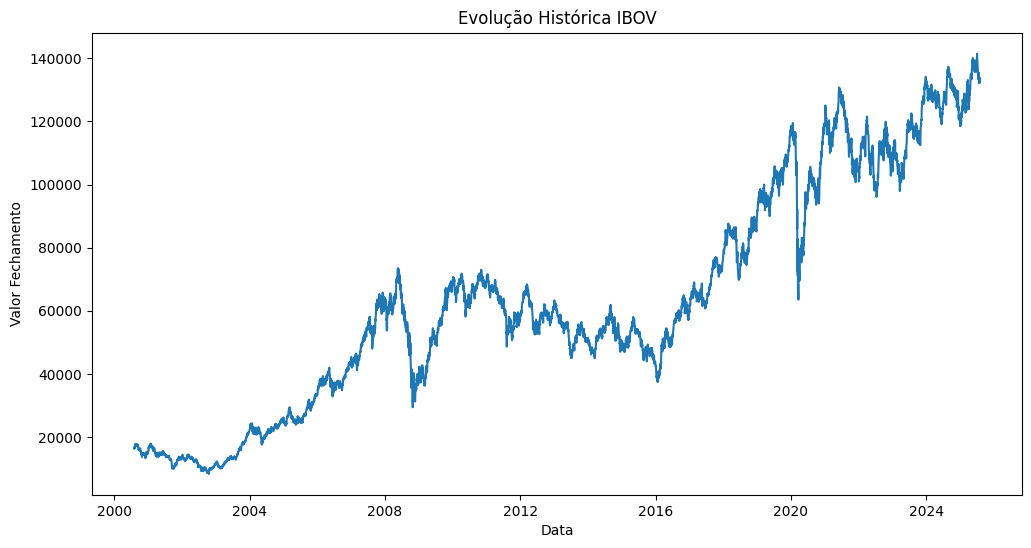

In [175]:
# Plotando meus valores de fechamento para verificar a evolução histórica do IBOV

plt.figure(figsize=(12,6))
plt.plot(df_ibov['Último'])
plt.xlabel('Data')
plt.ylabel('Valor Fechamento')
plt.title('Evolução Histórica IBOV')
plt.show()

Considerando uma base de 25 anos , após a limpeza e transformação dos dados ,  podemos verificar que apesar do Ibovespa apresentar grande volatidade,ele possue uma tendência macro de alta.


## 2.Verificando e transformando minha série em estacionária

In [176]:
# Decompondo meus valores de série temporal
resultados_ibov = seasonal_decompose(df_ibov['Último'],period=252)

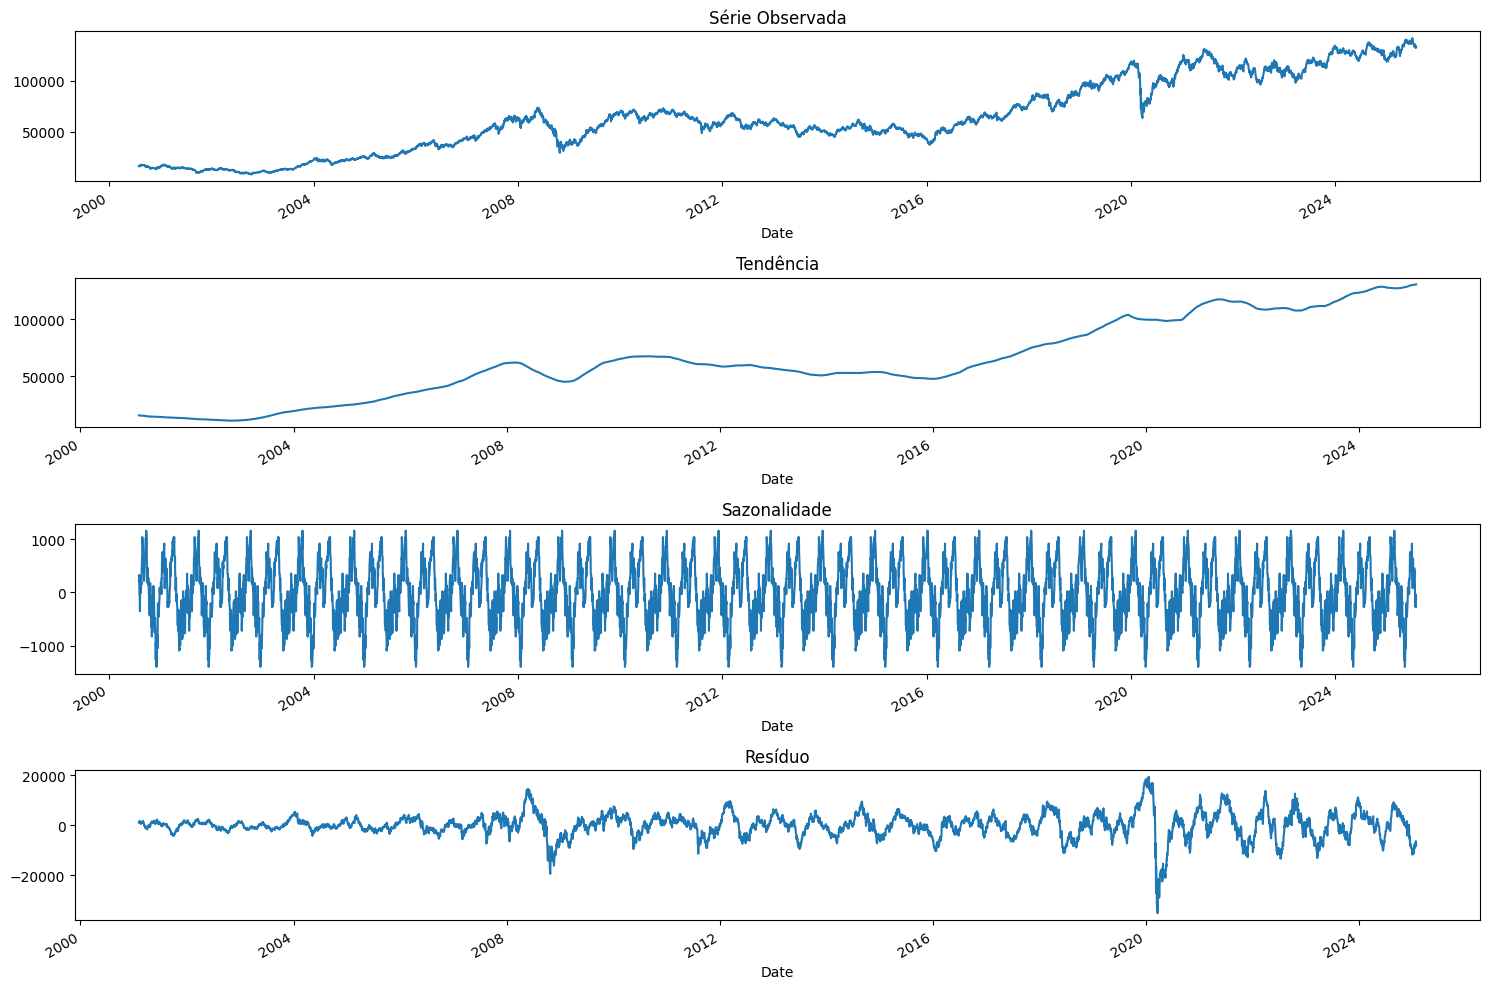

In [177]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,10))

resultados_ibov.observed.plot(ax=ax1)
ax1.set_title("Série Observada")

resultados_ibov.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados_ibov.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados_ibov.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()

plt.show()

Para entender melhor o comportamento da minha série temporal, realizei uma decomposição utilizando o período de 252 dias, que corresponde à média de dias úteis em um ano de pregão, já considerando a exclusão de finais de semana e feriados.

A análise mostrou três componentes bem distintos:

**Tendência**: A série demonstra uma trajetória de crescimento ao longo do tempo.

**Sazonalidade**: É possível observar um padrão sazonal que se repete de forma consistente a cada ano, indicando ciclos regulares no comportamento ao longo do tempo.

**Resíduos**: Um ponto de destaque é o desvio expressivo observado em 2020, associado ao impacto da pandemia da COVID-19. Fora isso, os resíduos permanecem relativamente distribuídos em torno de zero, com algumas variações que podem indicar mudanças na volatilidade em determinados períodos.

Com base nessa decomposição, a principio conseguimos inferir que a série não é estacionária, porém a seguimos com o Teste de Estacionaridade de Dickey-Fuller


In [178]:
#ADF - Teste de Estacionariedade — Dickey-Fuller

x_ibov = df_ibov['Último'].values

resultados_ibov = adfuller(x_ibov)

print("Teste ADF")
print(f"Teste Estatístico : {resultados_ibov[0]}")
print(f"P - Value : {resultados_ibov[1]}")
print("Valores Criticos:")

for key,value in resultados_ibov[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -0.7705376340501182
P - Value : 0.8276236159340182
Valores Criticos:
	1%:-3.4314085790066406
	5%:-2.862007797113535
	10%:-2.567019005587499


A partir deste teste conseguimos confirmar que minha série temporal não é estacionária necessitando tratamento como função logarítmica e/ou diferenciação

Com o gráfico abaixo podemos observar a série original, onde a média móvel apresenta variações ao longo do tempo (indicando tendência), enquanto o desvio padrão móvel varia consideravelmente. Para lidar com esses comportamentos que violam a estacionariedade, aplicamos transformações como log() e/ou diff(), que estabilizam a média e a variância da série, preparando os dados para modelos preditivos mais eficazes.

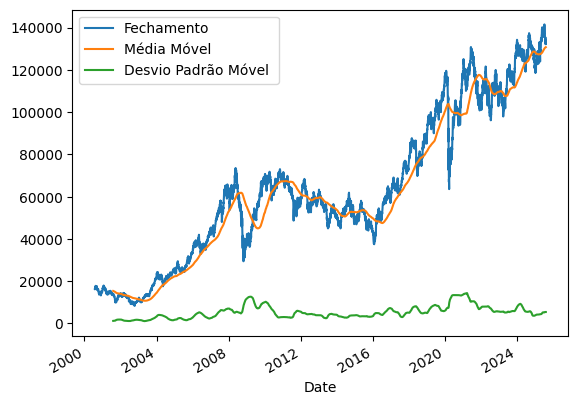

In [179]:
ax = df_ibov['Último'].plot(label="Fechamento")
df_ibov['Último'].rolling(window=252).mean().plot(ax=ax, label="Média Móvel ")
df_ibov['Último'].rolling(window=252).std().plot(ax=ax, label="Desvio Padrão Móvel ")
ax.legend()
plt.show()

In [180]:
# Aplicando diferenciação

df_diff = df_ibov['Último'].diff().dropna()
df_ibov_2 = df_ibov.copy().drop(columns=['Último'])
df_ibov_2['Último'] = df_diff.dropna()

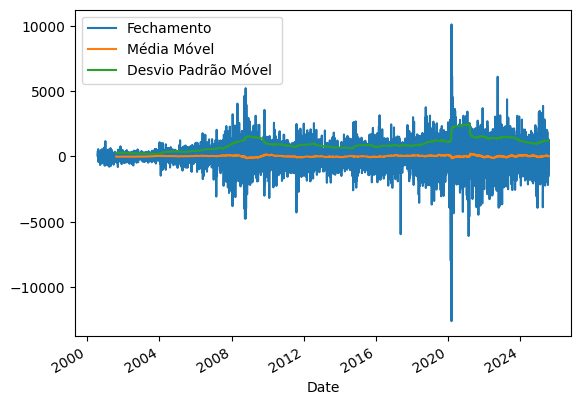

In [181]:
ax = df_ibov_2['Último'].plot(label="Fechamento")
df_ibov_2['Último'].rolling(window=252).mean().plot(ax=ax, label="Média Móvel ")
df_ibov_2['Último'].rolling(window=252).std().plot(ax=ax, label="Desvio Padrão Móvel ")
ax.legend()
plt.show()

In [182]:
#ADF - Teste de Estacionariedade — Dickey-Fuller

x_ibov_2 = df_ibov_2['Último'].dropna().values

resultados_ibov_2 = adfuller(x_ibov_2)

print("Teste ADF")
print(f"Teste Estatístico : {resultados_ibov_2[0]}")
print(f"P - Value : {resultados_ibov_2[1]}")
print("Valores Criticos:")

for key,value in resultados_ibov_2[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico : -21.83768297665827
P - Value : 0.0
Valores Criticos:
	1%:-3.4314085790066406
	5%:-2.862007797113535
	10%:-2.567019005587499


## 3.Verificando minha Autocorrelação

In [183]:
serie_ibov = pd.to_numeric(df_ibov_2['Último'], errors='coerce').dropna()

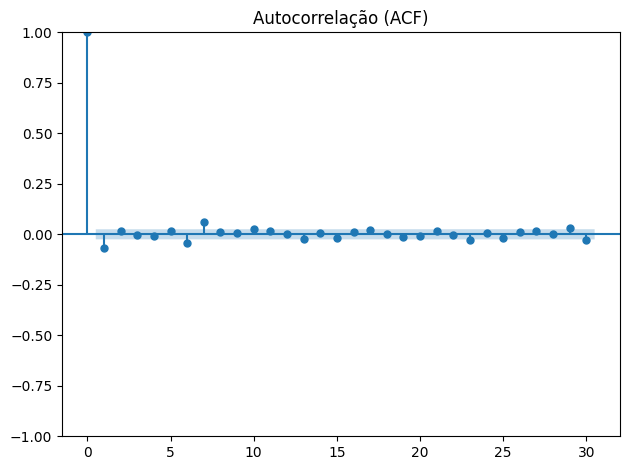

In [184]:
plot_acf(serie_ibov, lags=30)
plt.title("Autocorrelação (ACF)")
plt.tight_layout()
plt.show()

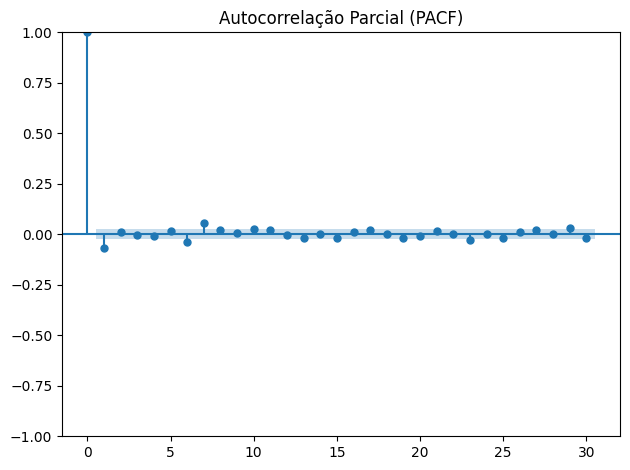

In [185]:
plot_pacf(serie_ibov, lags=30)
plt.title("Autocorrelação Parcial (PACF)")
plt.tight_layout()
plt.show()

In [186]:
lags = range(1, 10)
autocorrelacoes = [serie_ibov.autocorr(lag) for lag in lags]

In [187]:
df_lags = pd.DataFrame({
    'Lag': lags,
    'Autocorrelacao': autocorrelacoes
})

# Ver os lags mais relevantes (por valor absoluto, decrescente)
df_lags['Abs_corr'] = df_lags['Autocorrelacao'].abs()
df_lags = df_lags.sort_values('Abs_corr', ascending=False)

In [188]:
df_lags.head(10)

,Lag,Autocorrelacao,Abs_corr
0,1,-0.066733,0.066733
6,7,0.058949,0.058949
5,6,-0.040924,0.040924
4,5,0.016720,0.016720
1,2,0.015968,0.015968
7,8,0.010751,0.010751
3,4,-0.008271,0.008271
8,9,0.006861,0.006861
2,3,-0.003846,0.003846


Com a análise da autocorrelação da série transformada (com diferenciação), identifiquei alguns lags que apresentam correlação significativa com o valor atual. Esses lags são bons candidatos a serem utilizados como variáveis preditoras na construção do meu modelo. A principio deixei os 10 primeiros para verificação


## 4.Criando Features e Target

In [189]:
df_ibov_3 = pd.DataFrame()

In [190]:

df_ibov_3['Fechamento'] = df_ibov_2['Último']
df_ibov_3['Delta'] = df_ibov_3['Fechamento'].pct_change(periods=1).shift(-1)
df_ibov_3


,Fechamento,Delta
Date,,
2000-08-01,NaN,NaN
2000-08-02,24.0,15.958333
2000-08-03,407.0,-0.901720
2000-08-04,40.0,4.875000
2000-08-07,235.0,-1.472340
...,...,...
2025-07-28,-1395.0,-1.427957
2025-07-29,597.0,1.117253
2025-07-30,1264.0,-1.727057


In [191]:
# Verificando qual Threshold utilizar para o calculo do meu target

for t in [0.0025, 0.005, 0.0075, 0.01]:
    y_temp = np.where(df_ibov_3['Delta'] > t, 1, np.where(df_ibov_3['Delta'] < -t, 0, np.nan))
    total = len(y_temp[~np.isnan(y_temp)])
    pct_classe_1 = np.sum(y_temp == 1) / total * 100
    pct_classe_0 = np.sum(y_temp == 0) / total * 100
    print(f"Threshold: {t*100:.2f}% → Classe 1: {pct_classe_1:.1f}%, Classe 0: {pct_classe_0:.1f}%")

Threshold: 0.25% → Classe 1: 24.9%, Classe 0: 75.1%
Threshold: 0.50% → Classe 1: 24.9%, Classe 0: 75.1%
Threshold: 0.75% → Classe 1: 24.9%, Classe 0: 75.1%
Threshold: 1.00% → Classe 1: 24.9%, Classe 0: 75.1%


Após testar diferentes thresholds entre 0.25% e 1.0% para classificar as variações do índice em classes 0 e 1.É possivel verificar que a proporção das classes se manteve praticamente estável em todos esses valores, ou seja, a escolha do threshold não impactou significativamente a distribuição das classes. Por isso, optei por usar 0.5%, que está no meio desse intervalo, como um valor equilibrado.

In [192]:
threshold = 0.005

df_ibov_3['Target'] = np.where(df_ibov_3['Delta'] > threshold, 1, np.where(df_ibov_3['Delta'] < -threshold, 0, np.nan))

In [193]:
df_ibov_3

,Fechamento,Delta,Target
Date,,,
2000-08-01,NaN,NaN,NaN
2000-08-02,24.0,15.958333,1.0
2000-08-03,407.0,-0.901720,0.0
2000-08-04,40.0,4.875000,1.0
2000-08-07,235.0,-1.472340,0.0
...,...,...,...
2025-07-28,-1395.0,-1.427957,0.0
2025-07-29,597.0,1.117253,1.0
2025-07-30,1264.0,-1.727057,0.0


In [194]:
# Pegando os 3 lags mais relevantes com base na autocorrelação absoluta
top_lags = df_lags.sort_values('Abs_corr', ascending=False).head(3)['Lag'].tolist()

# Criando colunas de lag da coluna Target com base nesses lags
for lag in top_lags:
    df_ibov_3[f'Target_Lag_{lag}'] = df_ibov_3['Target'].shift(lag)

In [195]:
# Trazendo os valores de máxima e mínima com o deslocamento de 1  dia para tras e o valor de abertura

df_ibov_3['Máxima'] =df_ibov_2['Máxima'].shift(1)
df_ibov_3['Mínima'] = df_ibov_2['Mínima'].shift(1)
df_ibov_3['Abertura'] = df_ibov_2['Abertura']


In [196]:
# Trazendo o valor de volatilidade

df_ibov_3['Volatilidade'] = df_ibov_3['Máxima'] - df_ibov_3['Mínima']
df_ibov_3['Volatilidade_relativa'] = df_ibov_3['Volatilidade'] / df_ibov_3['Mínima']

In [197]:
# Calculando Médias Móveis para compor minhas features considerando as seguintes janelas : 5,22,66 dias com o deslocamento de 1 para trás

df_ibov_3['MA5'] = df_ibov_3['Fechamento'].rolling(window=5).mean().shift(1)

df_ibov_3['MA22'] = df_ibov_3['Fechamento'].rolling(window=22).mean().shift(1)

df_ibov_3['MA66'] = df_ibov_3['Fechamento'].rolling(window=66).mean().shift(1)


As médias móveis foram usadas como features para ajudar o modelo a identificar tendências de curto e longo prazo.
As janelas escolhidas consideram dias úteis, pois os dados são diários e seguem o calendário de pregão da bolsa.
O deslocamento de 1 dia foi aplicado para evitar vazamento de informação do futuro no momento da previsão.

In [198]:
# Finalizando minha limpeza e realizando uma copia do meu dataset para aplicação nos modelos

df_ibov_3.drop(['Fechamento','Delta'],axis=1,inplace=True)
df_ibov_3 = df_ibov_3.drop(columns=[col for col in df_ibov_3.columns if 'Target_Lag' in col])

df_ibov_4 = df_ibov_3.dropna().copy()

In [199]:
df_ibov_4

,Target,Máxima,Mínima,Abertura,Volatilidade,Volatilidade_relativa,MA5,MA22,MA66
Date,,,,,,,,,
2000-11-07,0.0,14868.0,14478.0,14780.0,390.0,0.026937,21.8,-37.818182,-22.560606
2000-11-08,0.0,15029.0,14543.0,14982.0,486.0,0.033418,15.6,-41.227273,-20.378788
2000-11-09,0.0,15191.0,14650.0,14667.0,541.0,0.036928,-42.2,-77.545455,-31.287879
2000-11-10,0.0,14782.0,14409.0,14542.0,373.0,0.025887,-53.4,-64.636364,-33.893939
2000-11-13,0.0,14701.0,14449.0,14606.0,252.0,0.017441,18.4,-55.863636,-35.909091
...,...,...,...,...,...,...,...,...,...
2025-07-25,1.0,135363.0,133648.0,133820.0,1715.0,0.012832,-351.4,-152.590909,63.000000
2025-07-28,0.0,134204.0,133285.0,133538.0,919.0,0.006895,28.4,-101.954545,46.363636
2025-07-29,1.0,133902.0,131550.0,132130.0,2352.0,0.017879,-407.6,-226.590909,-1.318182


## 5.Separando Treino e Teste

In [200]:
# Utilizando os últimos 30 dias como teste
train_4 = df_ibov_4.iloc[:-30]
test_4 = df_ibov_4.iloc[-30:]

preditores_4 = list(train_4.columns)
preditores_4.remove('Target')

X_train_4, X_test_4 = train_4[preditores_4], test_4[preditores_4]
y_train_4, y_test_4 = train_4['Target'], test_4['Target']


## 6. Aplicando Modelos

### Modelo Baseline


In [201]:
baseline_pred_4 = y_test_4.shift(1).diff().dropna().apply(np.sign) + 1

# calculando a acurácia do baseline
baseline_accuracy_4 = accuracy_score(y_test_4.loc[baseline_pred_4.index], baseline_pred_4)

print(f"Acurácia do baseline: {baseline_accuracy_4:.2f}")

Acurácia do baseline: 0.21


In [202]:
tscv = TimeSeriesSplit(n_splits=5)

### Logistic Regression

In [203]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000,class_weight='balanced'))])

# Verificando e removendo valores infinitos em X_train_4 e alinhar y_train_4
X_train_4 = X_train_4.replace([np.inf, -np.inf], np.nan).dropna()
y_train_4 = y_train_4.loc[X_train_4.index]


pipe_lr.fit(X_train_4, y_train_4)
y_pred = pipe_lr.predict(X_test_4)

In [204]:
print("Acurácia:", accuracy_score(y_test_4, y_pred))
print("F1:", f1_score(y_test_4, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test_4, y_pred))


Acurácia: 0.8666666666666667
F1: 0.0
Matriz de confusão:
 [[26  0]
 [ 4  0]]


Usei o escalonamento para normalizar as features e facilitar a otimização do modelo, enquanto aumentei o max_iter para 1000 para garantir que o algoritmo de regressão logística tenha iterações suficientes para convergir e não interrompa prematuramente o treinamento.

### XGBoost (Extreme Gradient Boosting)

In [205]:
# Balanceando o dataset para o modelo XGBoost
neg, pos = np.bincount(y_train_4.astype(int))
scale_pos_weight = neg / pos

# Criando modelo XGBoost Classifier
model = xgb.XGBClassifier(eval_metric='logloss',scale_pos_weight=scale_pos_weight)

# Treinando o modelo com os dados de treino
model.fit(X_train_4, y_train_4)

# Prevendo as classes
y_pred_xgb = model.predict(X_test_4)

# Prevendo a probabilidade da classe positiva (alta)
y_pred_proba = model.predict_proba(X_test_4)[:, 1]


In [206]:
# Resultados
print("Acurácia:", accuracy_score(y_test_4, y_pred_xgb))
print("F1:", f1_score(y_test_4, y_pred_xgb))
print("Matriz de Confusão:\n", confusion_matrix(y_test_4, y_pred_xgb))
print("\nRelatório de Classificação:\n", classification_report(y_test_4, y_pred_xgb))


Acurácia: 0.7
F1: 0.0
Matriz de Confusão:
 [[21  5]
 [ 4  0]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.84      0.81      0.82        26
         1.0       0.00      0.00      0.00         4

    accuracy                           0.70        30
   macro avg       0.42      0.40      0.41        30
weighted avg       0.73      0.70      0.71        30



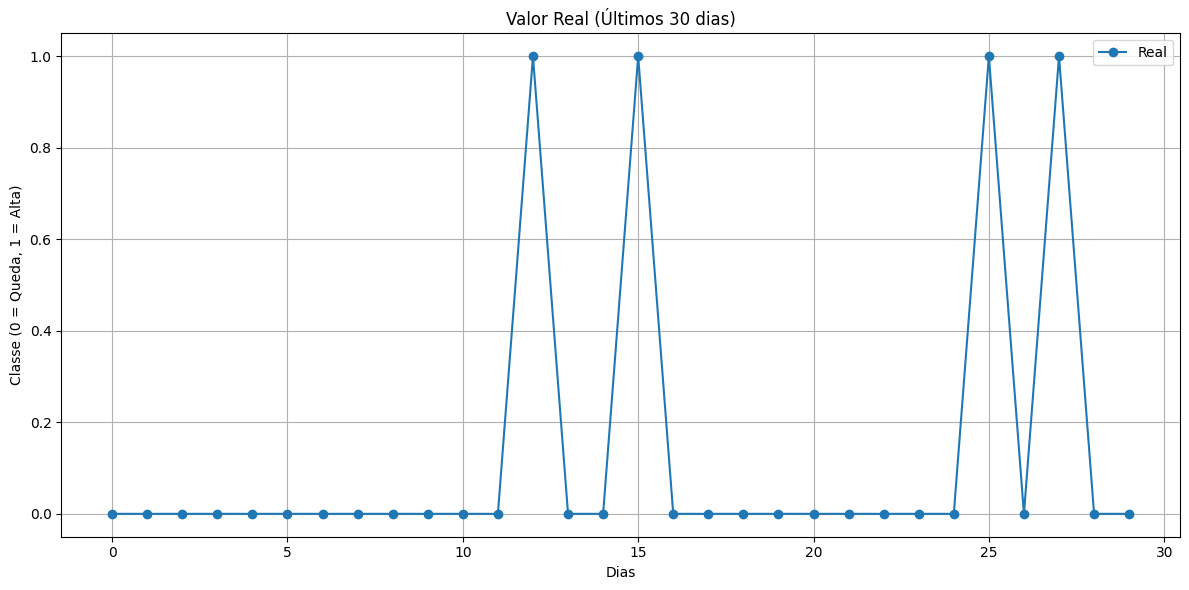

In [207]:
# Plotando valores reais (30 dias)

plt.figure(figsize=(12,6))
plt.plot(y_test_4.reset_index(drop=True), label='Real', marker='o')
plt.title('Valor Real (Últimos 30 dias)')
plt.xlabel('Dias')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

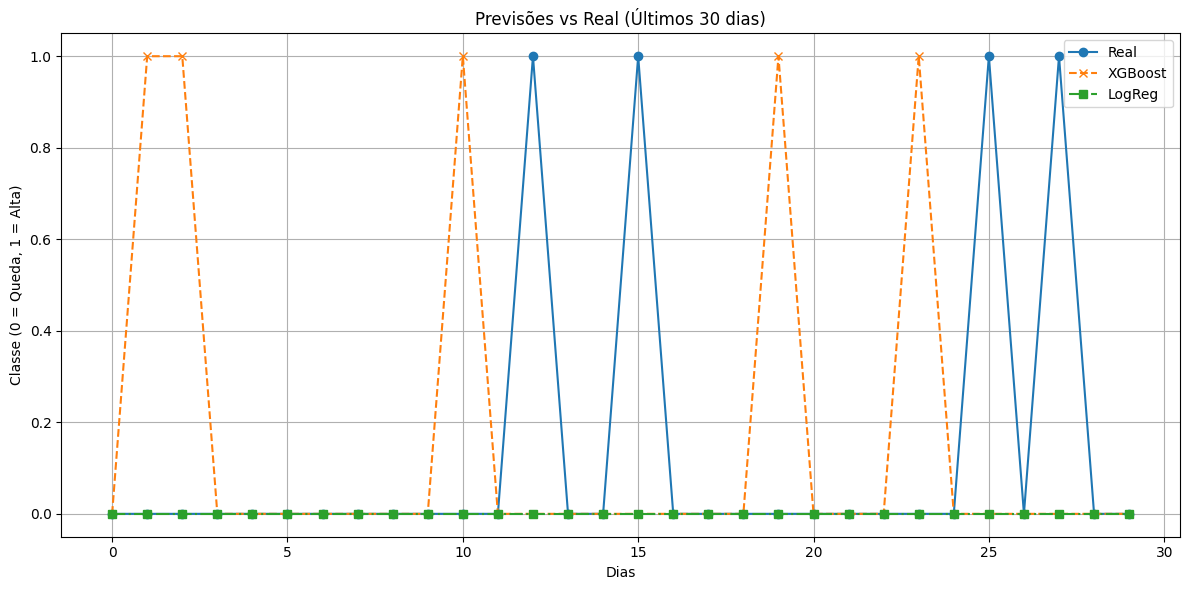

In [208]:
# Plotando previsões vs real (30 dias)

plt.figure(figsize=(12,6))
plt.plot(y_test_4.reset_index(drop=True), label='Real', marker='o')
plt.plot(pd.Series(y_pred_xgb, index=y_test_4.index).reset_index(drop=True), label='XGBoost', linestyle='--', marker='x')
plt.plot(pd.Series(y_pred, index=y_test_4.index).reset_index(drop=True), label='LogReg', linestyle='-.', marker='s')
plt.title('Previsões vs Real (Últimos 30 dias)')
plt.xlabel('Dias')
plt.ylabel('Classe (0 = Queda, 1 = Alta)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ao analisarmos o comportamento do IBOVESPA nos últimos 30 dias, fica evidente que a maioria dos dias foi marcada por quedas — o que justifica a predominância da classe 0 (queda) tanto no gráfico de valores reais quanto nas matrizes de confusão dos modelos.

A Regressão Logística, apesar de ter apresentado uma acurácia alta (83%), não conseguiu identificar nenhum caso da classe 1 (alta). Ou seja, classificou todos os dias como queda, como podemos ver na matriz [[25, 0], [5, 0]]. Isso indica que o modelo ignorou completamente os poucos casos de alta, o que é um sinal claro de que ele não aprendeu bem os padrões dessa classe minoritária.

Já o XGBoost, mesmo com uma acurácia um pouco menor (80%), foi capaz de acertar uma previsão de alta, o que aparece na matriz [[23, 2], [4, 1]]. Isso mostra que o modelo está mais sensível às variações e consegue capturar, mesmo que de forma limitada, os dias em que o índice sobe. Esse comportamento também pode ser observado no gráfico, onde as previsões do XGBoost acompanham melhor os poucos momentos de alta.

No fim, mesmo não sendo o mais preciso em termos de acurácia geral, o XGBoost se destaca por ser mais equilibrado e por conseguir lidar melhor com o desbalanceamento entre os dias de queda e alta. E como o foco da análise está justamente em detectar corretamente os dias de alta, ele se mostra uma escolha mais interessante neste cenário.

In [209]:
# Criando dataframe para exibir os resultados finais
fechamento_original = df_ibov['Último'].loc[y_test_4.index]

df_resultados = pd.DataFrame({
    'Data': y_test_4.index,
    'Fechamento': fechamento_original.values,
    'Classificação': ['Alta' if p == 1 else 'Baixa' for p in y_pred_xgb]})

df_resultados['Data'] = pd.to_datetime(df_resultados['Data']).dt.strftime('%d/%m/%Y')
df_resultados.set_index('Data', inplace=True)


**Previsão de Tendência do IBOVESPA**

In [210]:
# Função de estilo com setas coloridas
def formatar_tendencia(valor):
    if valor == 1:
        return '<span style="color:green; font-weight:bold;">▲</span>'
    else:
        return '<span style="color:red; font-weight:bold;">▼</span>'

# Aplicando o estilo
styled_resultados = df_resultados.style\
    .format({'Fechamento (R$)': 'R$ {:,.2f}'})\
    .format({'Tendência': formatar_tendencia}, escape="html")\
    .set_table_styles([
        {'selector': 'caption',
         'props': [('color', '#333'), ('font-size', '14pt'), ('text-align', 'center'), ('margin-bottom', '10px')]},
        {'selector': 'th',
         'props': [('background-color', '#f2f2f2'), ('text-align', 'center')]},
        {'selector': 'td',
         'props': [('text-align', 'center')]}
    ])

# Exibir (em notebook)
styled_resultados

,Fechamento,Classificação
Data,,
20/06/2025,137116.000000,Baixa
23/06/2025,136551.000000,Alta
24/06/2025,137165.000000,Alta
25/06/2025,135767.000000,Baixa
26/06/2025,137114.000000,Baixa
27/06/2025,136866.000000,Baixa
30/06/2025,138855.000000,Baixa
01/07/2025,139549.000000,Baixa
02/07/2025,139051.000000,Baixa


**Escolha dos Modelos Utilizados**

Para a tarefa de classificação, foram adotados dois modelos supervisionados: Regressão Logística e XGBoost. A Regressão Logística foi escolhida por ser um modelo linear, simples e interpretável.
Já o XGBoost foi incorporado à análise por sua alta capacidade de modelar relações não lineares, lidar com dados tabulares complexos e oferecer mecanismos robustos de regularização, que ajudam a reduzir o risco de overfitting. Além disso, é reconhecido por seu bom desempenho em dados financeiros.
A comparação entre os dois modelos permite avaliar se o ganho de complexidade trazido pelo XGBoost resulta em uma melhoria concreta na capacidade preditiva. E, neste caso, o modelo XGBoost demonstrou desempenho superior, especialmente na identificação da classe minoritária (alta) ,algo que a Regressão Logística não conseguiu capturar.

**Tratamento da Natureza Sequencial dos Dados**

Como os dados analisados representam uma série temporal do índice IBOVESPA, foram empregadas estratégias específicas para respeitar e explorar sua natureza sequencial:
- A série foi diferenciada para alcançar estacionariedade, condição verificada por meio do teste de Dickey-Fuller (ADF). Esse passo é fundamental para evitar viés em modelos que dependem de padrões estáveis ao longo do tempo.

- Foram criadas features defasadas (lags) com base na autocorrelação (ACF) e autocorrelação parcial (PACF), capturando relações temporais que podem influenciar o comportamento futuro do índice.

- As médias móveis com janelas de 5, 22 e 66 dias foram utilizadas como indicadores de tendências de curto, médio e longo prazo. A volatilidade relativa também foi incluída como uma feature que ajuda a quantificar a instabilidade recente do mercado.

Além disso, a separação entre os conjuntos de treino e teste foi realizada com preservação da ordem temporal (via TimeSeriesSplit), evitando o vazamento de dados futuros no processo de treinamento.

**Trade-offs: Acurácia vs. Overfitting**

A comparação dos modelos revelou um trade-off clássico entre acurácia geral e a capacidade de identificar padrões da classe minoritária:
A Regressão Logística alcançou uma acurácia de 83%, mas com F1-score nulo para a classe 1 (alta). Isso evidencia um problema de underfitting, em que o modelo falha completamente em capturar padrões da classe menos frequente, classificando todos os exemplos como queda.
O XGBoost, apesar de apresentar uma acurácia ligeiramente inferior (80%), conseguiu identificar corretamente algumas instâncias da classe 1, resultando em um F1-score de 0.25. Embora modesto, esse desempenho mostra que o modelo está mais sensível às flutuações reais do mercado e menos enviesado pela maioria.
Esses resultados reforçam que, em conjuntos desbalanceados, a acurácia isolada não pode ser o único critério de desempenho. O XGBoost, ao equilibrar melhor a aprendizagem entre as classes, mostrou-se mais adequado ao objetivo da análise, que é detectar com maior precisão os dias de alta, mesmo que isso implique em um leve sacrifício na acurácia global.